# W07 From Tidy Data to Graphs

## Set Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import igraph as ig

## Get Data

In [2]:
data_file = "winereviews-DOC_SHORT.csv"
# data_file = "winereviews-DOC_MOD.csv"
DOC = pd.read_csv(data_file)
DOC = DOC.dropna(subset=['doc_taster', 'doc_country', 'doc_variety']) # Drop rows with nulls values in key cols

Get shape of data set.

In [3]:
DOC.shape

(71605, 19)

## Create Nodes and Edges

We are going to create a "bipartite" graph.

This means we are going to see how two categorical variables are related to each other.

So, let's begin by picking two columns we want to be nodes in our graph.

We'll choose Country and Variety.

In [4]:
node_cols = ['doc_country', 'doc_taster']

Now, let's create a `N` table by extracting the set of nodes from `DOC` using melt and value counts.

We'll also rename the columns and index of our resulting data frame. 

In [5]:
N = DOC[node_cols].melt().value_counts().to_frame('n')
N.index.names = ['type', 'label']
N = N.reset_index()
N.index.name = 'id'
N.head()

,type,label,n
id,,,
0,doc_country,US,31904
1,doc_taster,Roger Voss,14629
2,doc_country,France,13773
3,doc_taster,Michael Schachner,10071
4,doc_taster,Virginie Boone,8507


Now, let's create the `EDGES` table by extracting the edges from `DOC`.

Edges are just relationships between nodes.

Each row in `DOC` contains relationships between columns.

We'll just focus on the two columns we picked above.

In [6]:
EDGES = DOC[node_cols].value_counts().to_frame('n').reset_index()
EDGES.index.name = 'id'
EDGES.head()

,doc_country,doc_taster,n
id,,,
0,France,Roger Voss,11450
1,US,Virginie Boone,8507
2,US,Paul Gregutt,8223
3,Italy,Kerin O’Keefe,6298
4,US,Matt Kettmann,5172


In [7]:
NODES = DOC[node_cols].melt().value_counts().to_frame('n')
NODES.index.names = ['type', 'label']
NODES = NODES.reset_index()
NODES.index.name = 'id'
NODES.head()

,type,label,n
id,,,
0,doc_country,US,31904
1,doc_taster,Roger Voss,14629
2,doc_country,France,13773
3,doc_taster,Michael Schachner,10071
4,doc_taster,Virginie Boone,8507


Now, let's create the `EDGES` table by extracting the edges from `DOC`.

Edges are just relationships between nodes.

Each row in `DOC` contains relationships between columns.

We'll just focus on the two columns we picked above.

In [8]:
EDGES = DOC[node_cols].value_counts().to_frame('n').reset_index()
EDGES.index.name = 'id'
EDGES.head()

,doc_country,doc_taster,n
id,,,
0,France,Roger Voss,11450
1,US,Virginie Boone,8507
2,US,Paul Gregutt,8223
3,Italy,Kerin O’Keefe,6298
4,US,Matt Kettmann,5172


Now let's replace the names in the `EDGES` table with the ids from the `NODES` table.

This is not strictly necessary, but it is a good practice.

In [9]:
def replace_names_with_ids(col_name):
    
    # Check if we've already modified the EDGES table.
    if col_name not in EDGES.columns:
        return False
    
    # We create a version of NODES that contains only rows associated with the node type,
    # and where the index is the node label 
    X = NODES[NODES.type == col_name].reset_index().set_index('label')

    # We use .map() to replace the key of the X with the id column in X.
    EDGES[col_name] = EDGES[col_name].map(X.id)

for col in node_cols:
    replace_names_with_ids(col)

EDGES.columns = ['source', 'target', 'n']

In [10]:
EDGES.head()

,source,target,n
id,,,
0,2,1,11450
1,0,4,8507
2,0,5,8223
3,6,7,6298
4,0,8,5172


## Convert to Igraph
Now we convert our data frames into a graph object using Python's Igraph package.

In [11]:
# Create graph from EDGES
g = ig.Graph(edges=EDGES[['source', 'target']].values.tolist())
    
# Add vertex (node) attributes
g.vs['label'] = NODES.label.to_list() # [NODES.loc[i, 'label'] for i in range(len(NODES))]
g.vs['count'] = NODES.n.to_list() # [NODES.loc[i, 'n'] for i in range(len(NODES))]
g.vs['node_type'] = NODES.type.to_list() # [NODES.loc[i, 'type'] for i in range(len(NODES))]
    
# Add edge attributes
g.es['weight'] = EDGES['n'].tolist()

Save as GraphML file.

This file can be opened up in tools like Gephi and CytoScape.

In [12]:
g.write_graphml("wine-taster-country.graphml")

## Generalize

Break out into two functions.

In [13]:
def tidy_to_graph(df:pd.DataFrame, node_cols:list):
    """
    Converts columns from a tidy table into a graph comprised of NODES and EDGES data frames.

    Works for bipartite graphs -- graphs with connections between two columns.
    """

    # Create nodes
    NODES = df[node_cols].melt().value_counts().to_frame('n')
    NODES.index.names = ['type', 'label']
    NODES = NODES.reset_index()
    NODES.index.name = 'id'

    # Create edges
    EDGES = df[node_cols].value_counts().to_frame('n').reset_index()
    EDGES.index.name = 'id'

    # Function to replace node names with node ids in the EDGES data frame
    def replace_names_with_ids(col_name):
        # Temporary NODES table the selected nodes for column name and swaps the index to label        
        X = NODES[NODES.type == col_name].reset_index().set_index('label')
        # Replaces column value with id using .map()
        EDGES[col_name] = EDGES[col_name].map(X.id)

    # Replace names with ids in EDGES
    for col in node_cols:
        replace_names_with_ids(col)

    # Renames EDGES columns
    EDGES.columns = ['source', 'target', 'n']

    # Returns both data frames
    return NODES, EDGES


In [14]:
def graph_to_igraph(NODES:pd.DataFrame, EDGES:pd.DataFrame, directed:bool=False):
    """
    Converts NODES and EDGES directly into an igraph Graph object.
        """
    # Create graph from EDGES
    g = ig.Graph(edges=EDGES[['source', 'target']].values.tolist())
        
    # Add vertex (node) attributes
    g.vs['label'] = NODES['label'].to_list() # [NODES.loc[i, 'label'] for i in range(len(NODES))]
    g.vs['count'] = NODES['n'].to_list() # [NODES.loc[i, 'n'] for i in range(len(NODES))]
    g.vs['node_type'] = NODES['type'].to_list() # [NODES.loc[i, 'type'] for i in range(len(NODES))]
        
    # Add edge attributes
    g.es['weight'] = EDGES['n'].tolist()    
    
    return g

Test out the functions.

In [15]:
my_node_cols = ['doc_taster', 'doc_country']
E, N = tidy_to_graph(DOC, my_node_cols)
G = graph_to_igraph(E, N)
G.write_graphml("wine-taster-country.graphml")

In [16]:
my_node_cols = ['doc_country', 'doc_variety']
E, N = tidy_to_graph(DOC, my_node_cols)
G = graph_to_igraph(E, N)
G.write_graphml("FOO-wine-country-variety.graphml")

## Display with iGraph

In [17]:
g = graph_to_igraph(NODES, EDGES)

In [18]:
# g = ig.Graph.Read_GraphML("wine-taster-country.graphml")

See https://python.igraph.org/en/stable/tutorial.html#layout-algorithms for layout options.

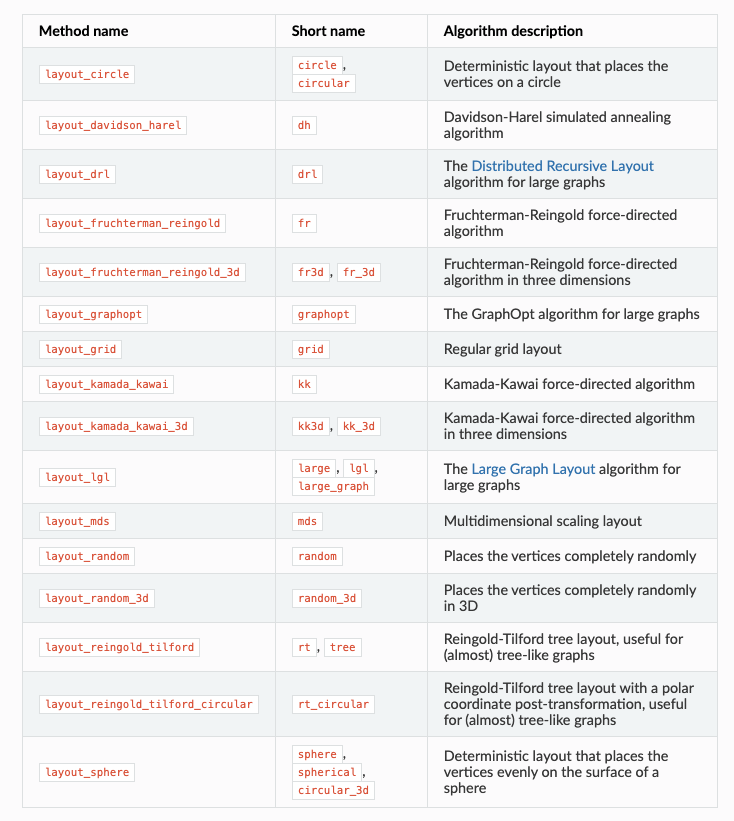

In [19]:
layout_type = "rt_circular"
# layout_type = 'dh'

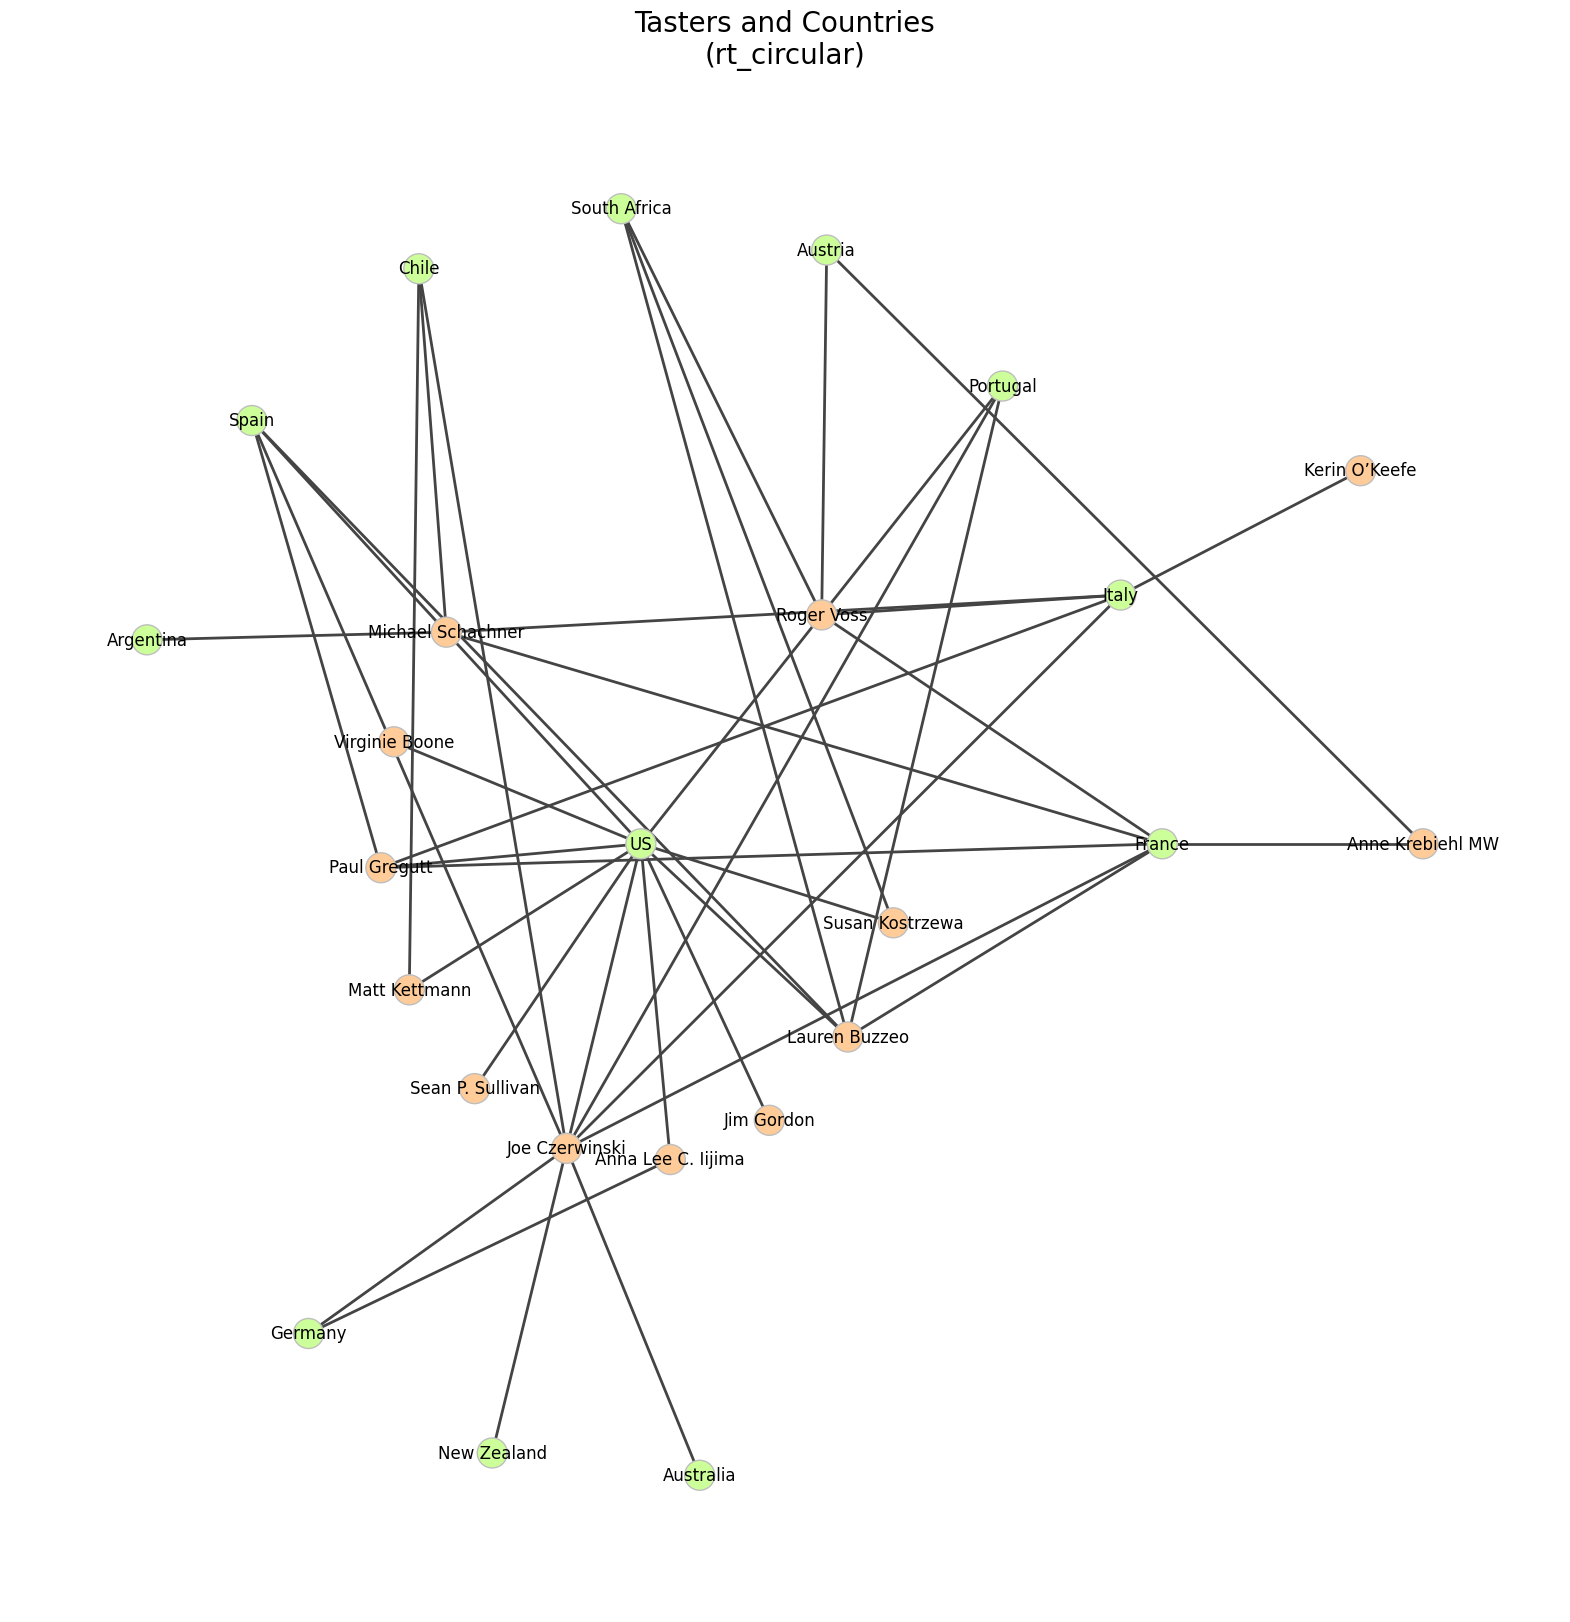

In [20]:
fig, ax = plt.subplots(figsize=(20,20))
ig.plot(
    g,
    target = ax,
    layout = layout_type,
    vertex_color =["#ccff99" if type == "doc_country" else "#ffcc99" for type in g.vs["node_type"]],    
    vertex_frame_width = 1.0,
    vertex_frame_color = "gray",
    vertex_label = g.vs["label"],
    vertex_label_size = 12.0,
)
plt.title(f"Tasters and Countries\n({layout_type})", fontsize=20)
plt.show()

Let's make the node sizes and edge widths proportional to their degrees.

In [21]:
egde_weight = pd.Series(g.es['weight'])
node_count = pd.Series(g.vs['count'])

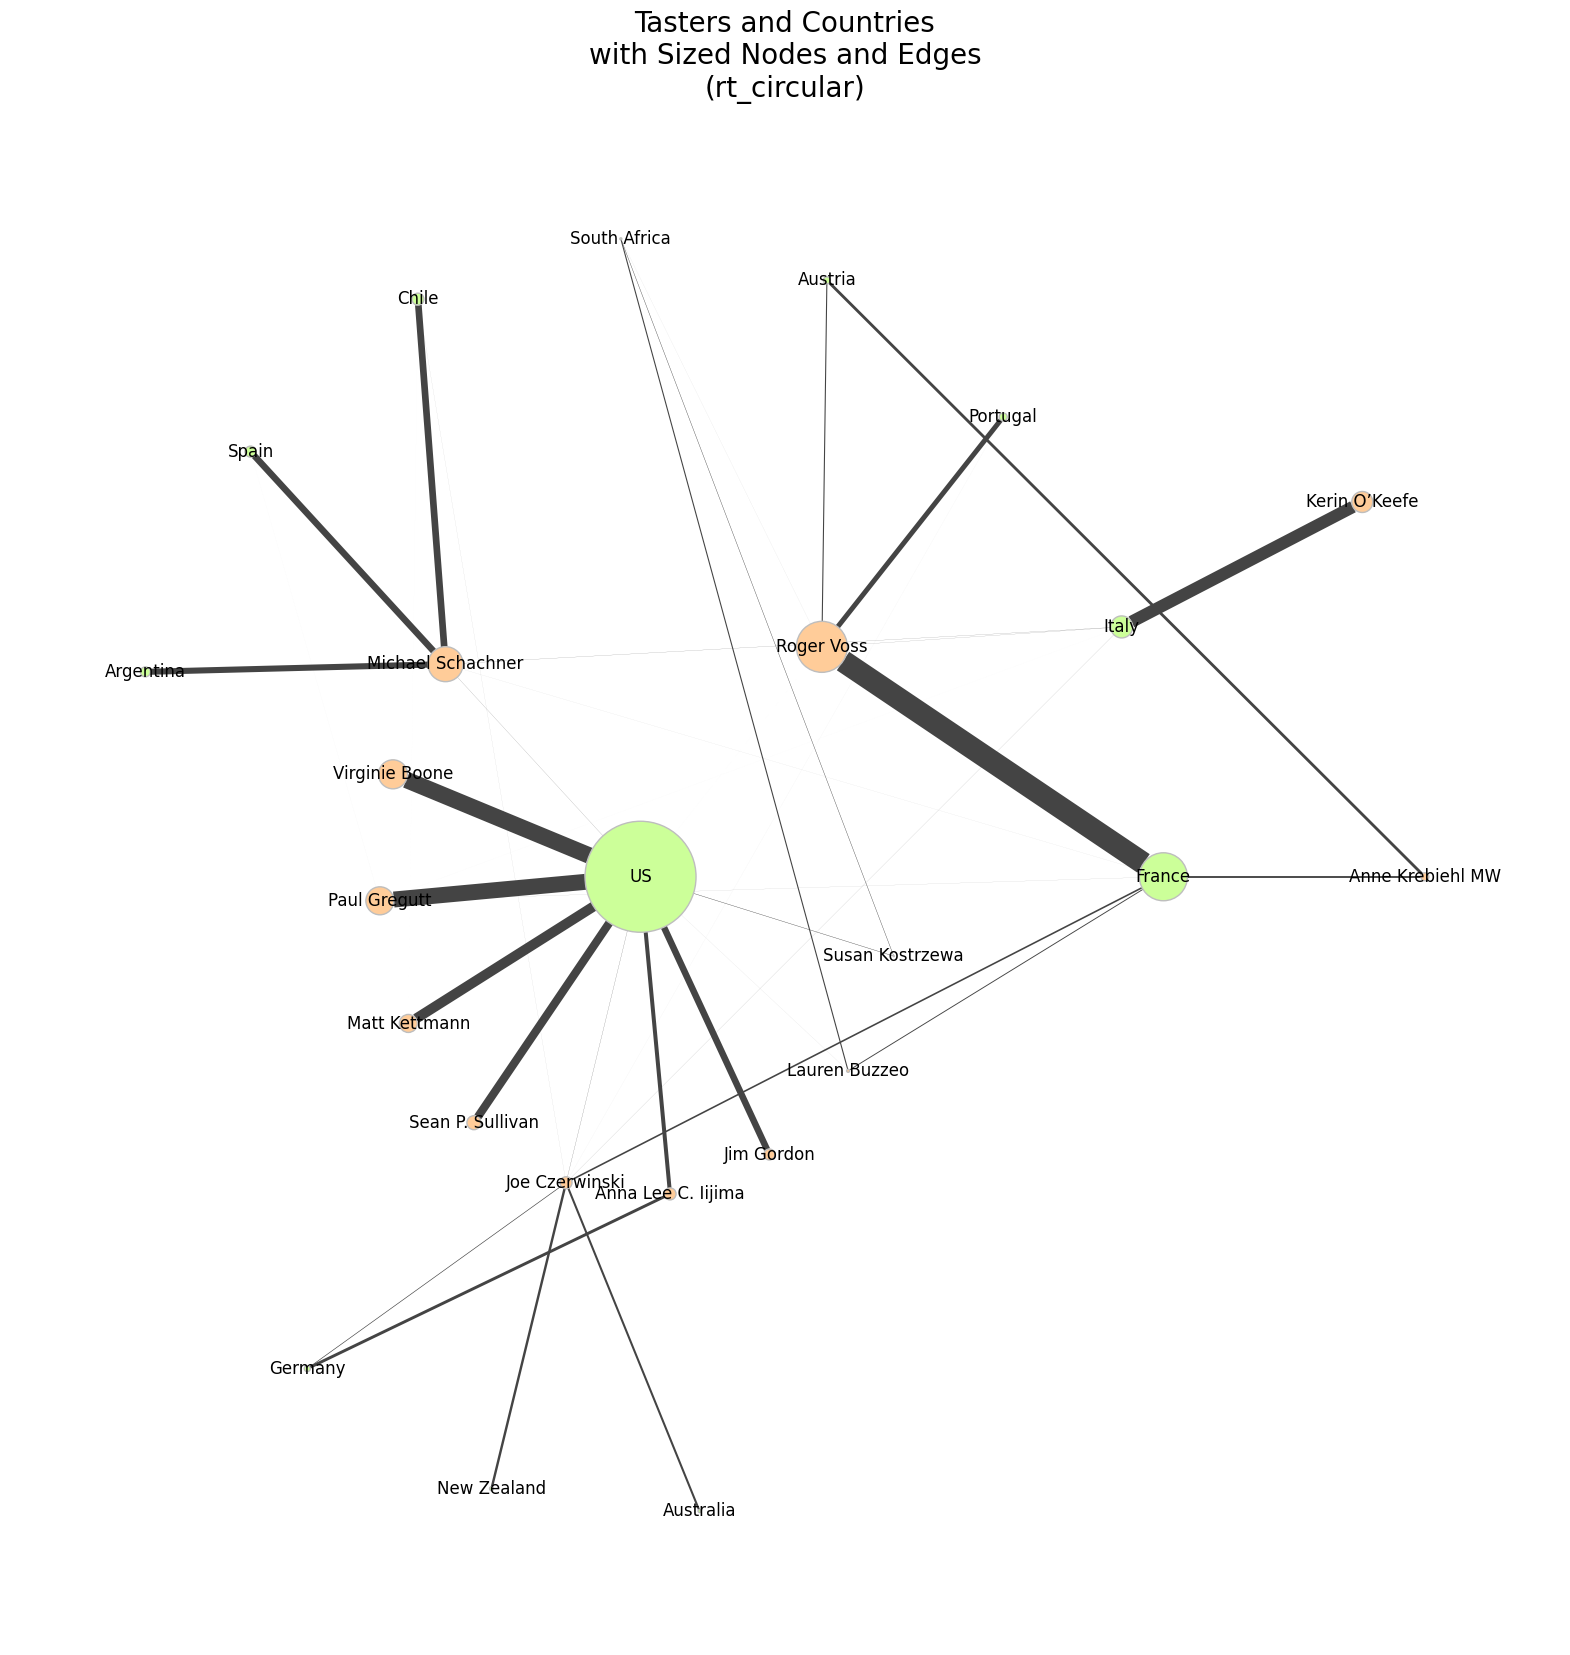

In [22]:
fig, ax = plt.subplots(figsize=(20,20))
ig.plot(
    g,
    target = ax,
    layout = layout_type,

    edge_width = (egde_weight / egde_weight.sum()) * 100,
    vertex_size = (node_count / node_count.sum()) * 500,

    vertex_color =["#ccff99" if type == node_cols[0] else "#ffcc99" for type in g.vs["node_type"]],    
    vertex_frame_width = 1.0,
    vertex_frame_color = "gray",
    vertex_label = g.vs["label"],
    vertex_label_size = 12.0,
)
plt.title(f"Tasters and Countries\nwith Sized Nodes and Edges\n({layout_type})", fontsize=20)
plt.show()

Write a helper function.

In [23]:
def graphplot(my_g, node_cols, layout_type='rt_circular', sized=False, title=None, figsize=(20,20)):
    
    if sized: 
        egde_weight = pd.Series(g.es['weight'])
        node_count = pd.Series(g.vs['count'])
        e_w = (egde_weight / egde_weight.sum()) * 100
        v_s = (node_count / node_count.sum()) * 500
    else:
        e_w = None
        v_s = None
    
    fig, ax = plt.subplots(figsize=figsize)
    ig.plot(
        my_g,
        target = ax,
        layout = layout_type,
        edge_width = e_w, 
        vertex_size = v_s, 
        vertex_color =["#ccff99" if type == node_cols[0] else "#ffcc99" for type in g.vs["node_type"]],    
        vertex_frame_width = 1.0,
        vertex_frame_color = "gray",
        vertex_label = g.vs["label"],
        vertex_label_size = 12.0,
    )
    plt.title(title, fontsize=20)
    plt.show()

Try it out.

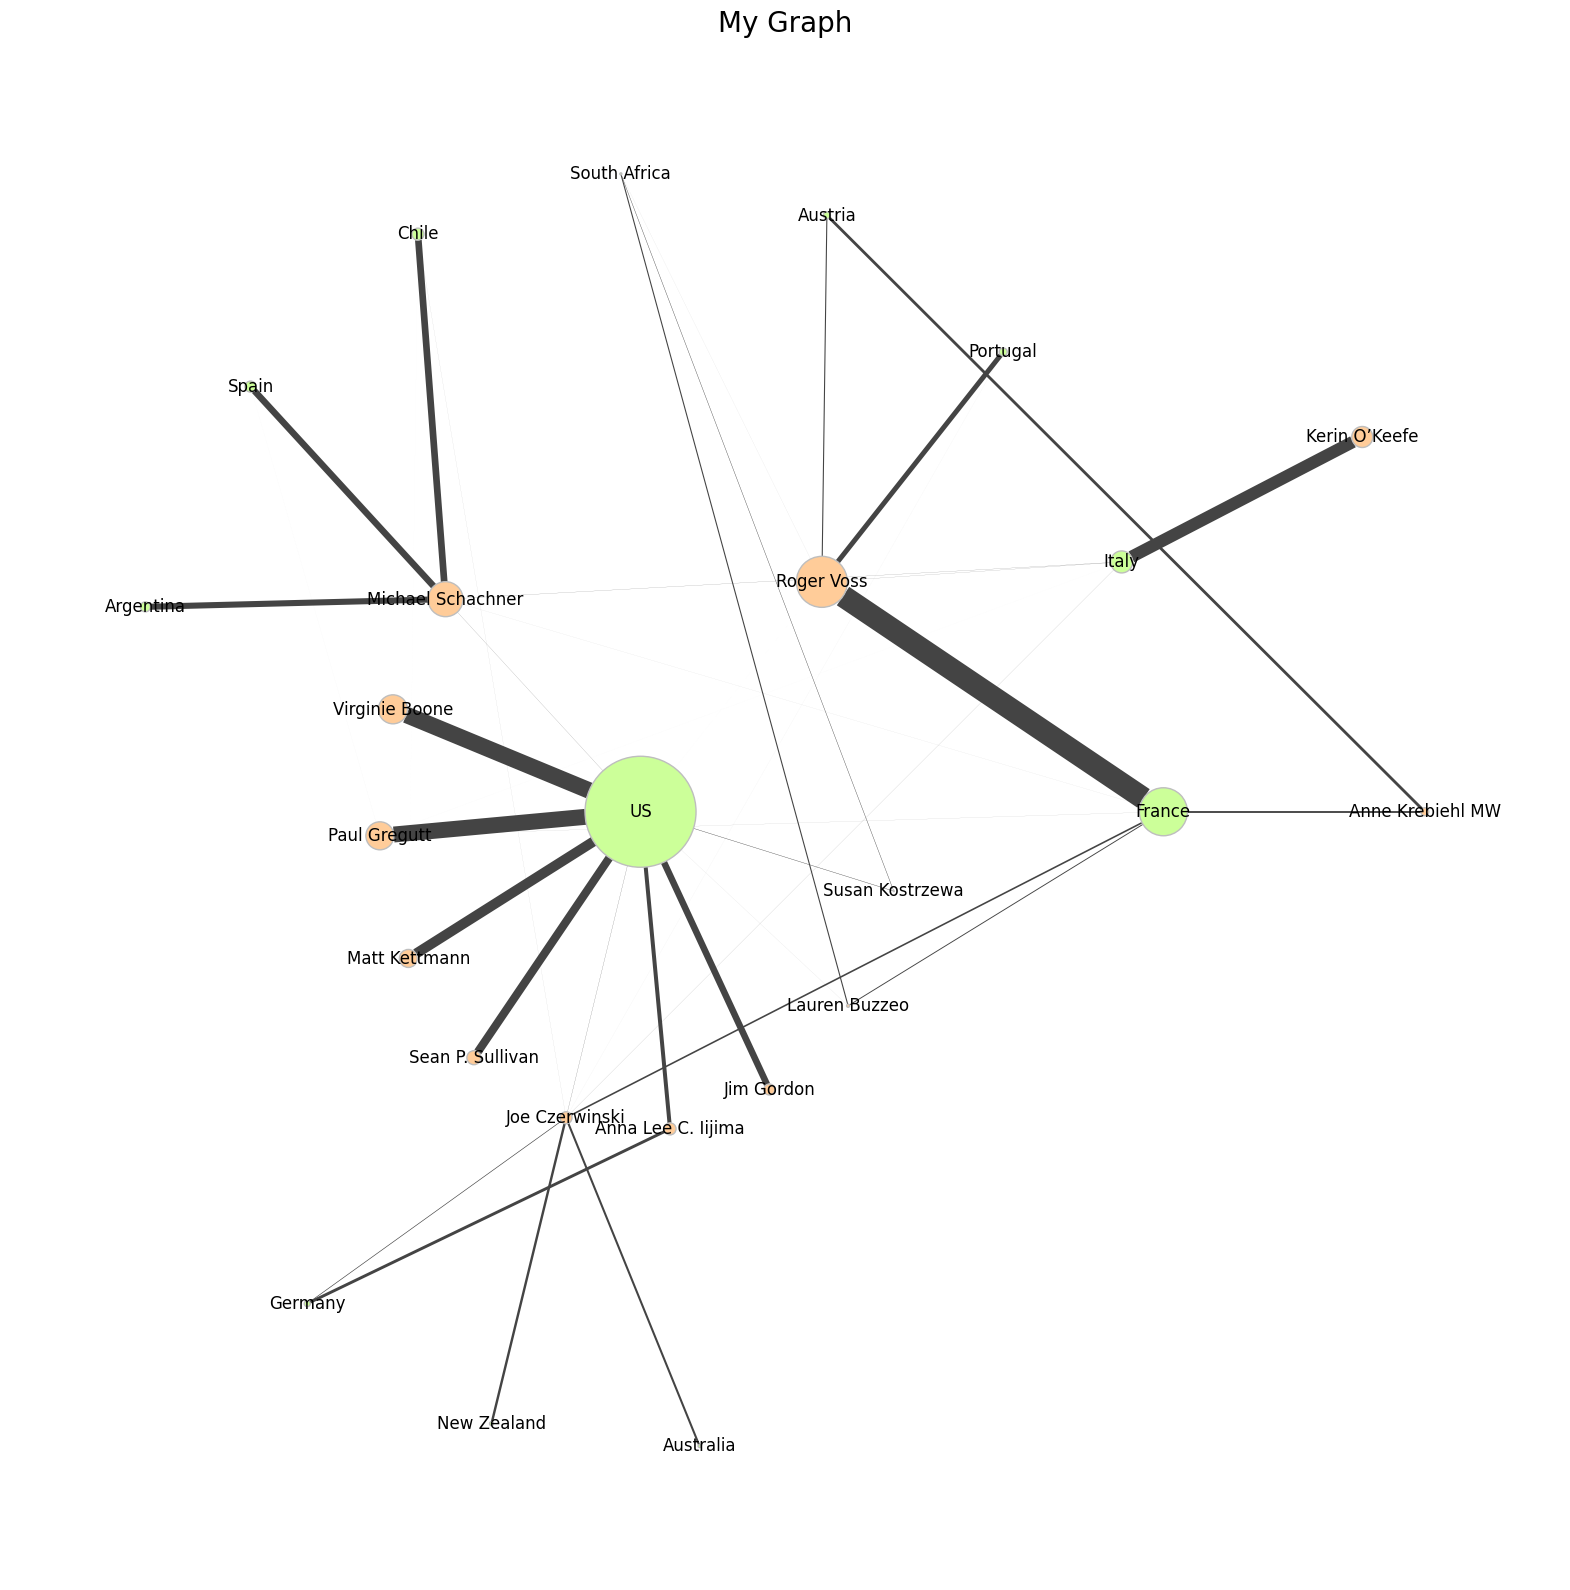

In [24]:
graphplot(g, node_cols=node_cols, layout_type=layout_type, title="My Graph", sized=True)